In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [2]:
class CustomBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
      # basic backbone block implementation
        super(CustomBlock, self).__init__()
        # initialise parameters for a
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_conv_layers)
        self.activation = nn.ReLU()
        # convulitional sequence which is later combined with vector A
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),

                #dropout at this rate gives me better results
                nn.Dropout(0.0008),
                
            ) for _ in range(num_conv_layers)
        ])

    def forward(self, x):
        b, c, h, w = x.size()
        # pooling the x
        pooled = self.avg_pool(x).view(b, c)
        #apply linear and use relu
        a = self.activation(self.fc(pooled))
        #combine each conv layer with each value in vector A
        out = sum(a[:, i].view(b, 1, 1, 1) * self.convs[i](x) for i in range(len(self.convs)))
        return out



In [4]:
class CustomBlockV2(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers=5):
        super(CustomBlockV2, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_channels, num_conv_layers)
        self.activation = nn.ReLU()
        # this block contains a conv layer with 2 convolutions 2 batchnorms and 2 dropouts
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(0.0006),
                nn.Conv2d(out_channels,out_channels,3,padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Dropout(0.0003),
                
            ) for _ in range(num_conv_layers)
        ])

    def forward(self, x):
        b, c, h, w = x.size()
        pooled = self.avg_pool(x).view(b, c)
        a = self.activation(self.fc(pooled))

        out = sum(a[:, i].view(b, 1, 1, 1) * self.convs[i](x) for i in range(len(self.convs)))
        return out

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [7]:
class CustomBlockCNN(nn.Module):
    def __init__(self, num_classes=10, num_blocks=1, num_conv_layers=2):
        super(CustomBlockCNN, self).__init__()

        self.blocks = nn.ModuleList([
            CustomBlock(3 if i == 0 else 64, 64, num_conv_layers)
            for i in range(num_blocks)
        ])

        self.batch_norm = nn.BatchNorm2d(64)

        self.custom_blocks = nn.Sequential(
            CustomBlockV2(64, 128,num_conv_layers),
            CustomBlockV2(128, 128,num_conv_layers),
            CustomBlockV2(128, 128,num_conv_layers),
        )

        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        for i, block in enumerate(self.blocks):
            out = block(x)
            if i > 0:
                x = x + out
            else:
                x = out
        x = self.batch_norm(x)
        x = self.custom_blocks(x)
        x = nn.AdaptiveAvgPool2d(1)(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

criterion = nn.CrossEntropyLoss()
num_epochs = 100

# Initialise the model
model = CustomBlockCNN().to(device)

# Higher initial learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-7)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

In [8]:
# Initializes variables to track running loss, number of correctly predicted training examples, and total number of training examples.
train_loss = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # Iteratively loops over the training data.
    for i, (inputs, labels) in enumerate(trainloader):
      # The input data and labels are moved to the selected device.
        inputs, labels = inputs.to(device), labels.to(device)
        # Resets the optimizer's gradients.
        optimizer.zero_grad()
        # The input data is fed into the model to make predictions.
        outputs = model(inputs)
        # Computes the difference between the predictions and the true labels.
        loss = criterion(outputs, labels)
        # The gradients of the loss with respect to the model parameters are computed.
        loss.backward()
        # The optimizer is used to update the model parameters.
        optimizer.step()
        # The current batch's loss is added to the running loss.
        running_loss += loss.item()
        # The number of successfully predicted training instances in this batch is computed and added to the running total.
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        # The learning rate scheduler is updated.
        scheduler.step()
    # Determines the epoch's average training loss and adds it to the train_loss list.
    train_loss.append(running_loss / (i + 1))
    # Calculates the epoch's training accuracy and adds it to the train_acc list.
    train_accuracy = 100 * correct_train / total_train
    train_acc.append(train_accuracy)
    # Puts the model in evaluation mode.
    model.eval()
    # Variables are set up to track the number of accurately anticipated validation examples as well as the total number of validation examples.
    correct = 0
    total = 0
    # Loops over the validation data in batches.
    with torch.no_grad():
        for inputs, labels in testloader:
          #The input data and labels are moved to the selected device.
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # The number of successfully predicted validation examples in this batch is computed and added to the running total.
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
         # Calculates the validation accuracy for the epoch and appends it to the val_acc list.
        accuracy = 100 * correct / total
        val_acc.append(accuracy)
        # Prints out the current epoch number, average training loss, training accuracy, and validation accuracy.
        print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1):.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.8122, Train Accuracy: 31.38%, Validation Accuracy: 50.76%
Epoch 2, Loss: 1.2580, Train Accuracy: 54.02%, Validation Accuracy: 41.08%
Epoch 3, Loss: 1.0522, Train Accuracy: 62.38%, Validation Accuracy: 67.92%
Epoch 4, Loss: 0.9240, Train Accuracy: 67.06%, Validation Accuracy: 54.16%
Epoch 5, Loss: 0.8411, Train Accuracy: 70.18%, Validation Accuracy: 73.96%
Epoch 6, Loss: 0.7648, Train Accuracy: 73.07%, Validation Accuracy: 60.76%
Epoch 7, Loss: 0.7108, Train Accuracy: 74.80%, Validation Accuracy: 77.30%
Epoch 8, Loss: 0.6534, Train Accuracy: 77.10%, Validation Accuracy: 62.22%
Epoch 9, Loss: 0.6218, Train Accuracy: 78.25%, Validation Accuracy: 80.04%
Epoch 10, Loss: 0.5846, Train Accuracy: 79.72%, Validation Accuracy: 64.23%
Epoch 11, Loss: 0.5550, Train Accuracy: 80.85%, Validation Accuracy: 81.43%
Epoch 12, Loss: 0.5245, Train Accuracy: 81.80%, Validation Accuracy: 74.56%
Epoch 13, Loss: 0.5041, Train Accuracy: 82.47%, Validation Accuracy: 83.01%
Epoch 14, Loss: 0.481

Epoch 97, Loss: 0.0587, Train Accuracy: 98.02%, Validation Accuracy: 88.92%

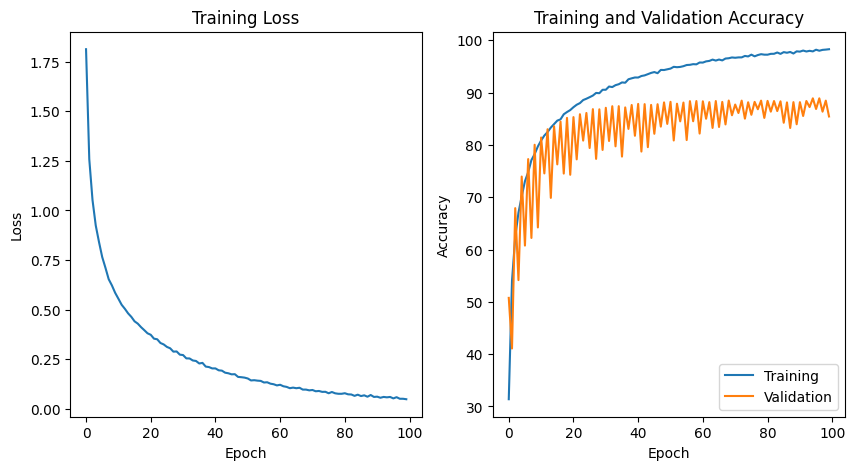

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label="Training")
plt.plot(val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
